In [4]:
# Instalação das bibliotecas necessárias
!pip install tensorflow keras numpy matplotlib scikit-learn

In [5]:
# Importação das bibliotecas
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import files

In [23]:
# Carregando o dataset Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Reduzindo o tamanho do dataset para testes rápidos
train_images_small = train_images[:1000]
test_images_small = test_images[:200]

# Normalizando os valores dos pixels para o intervalo [0, 1]
train_images_small = train_images_small / 255.0
test_images_small = test_images_small / 255.0

print("Dataset reduzido carregado com sucesso!")

Dataset reduzido carregado com sucesso!


In [25]:
# Carregando o modelo MobileNetV2 pré-treinado
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Função para extrair características de um conjunto de imagens (com processamento em lote)
def extract_features(images, batch_size=32):
    features = []
    num_images = len(images)

    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch_images = images[start:end]

        # Convertendo as imagens do lote para RGB
        batch_rgb = np.stack([np.stack((img,) * 3, axis=-1) for img in batch_images], axis=0)

        # Redimensionando as imagens para 224x224 (entrada do MobileNetV2)
        batch_resized = tf.image.resize(batch_rgb, [224, 224]).numpy()

        # Pré-processamento das imagens
        batch_preprocessed = preprocess_input(batch_resized)

        # Extraindo características do lote
        batch_features = base_model.predict(batch_preprocessed)
        features.append(batch_features)

    # Concatenando todas as características extraídas
    return np.vstack(features)

# Extraindo características das imagens de treino e teste
train_features = extract_features(train_images_small, batch_size=32)
test_features = extract_features(test_images_small, batch_size=32)

print("Características extraídas com sucesso!")

<ipython-input-25-bdb26c10d8ce>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [26]:
# Treinando o modelo Nearest Neighbors
n_neighbors = 5  # Número de vizinhos mais próximos
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
nn_model.fit(train_features)

print("Modelo de similaridade treinado com sucesso!")

Modelo de similaridade treinado com sucesso!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Imagem de consulta:


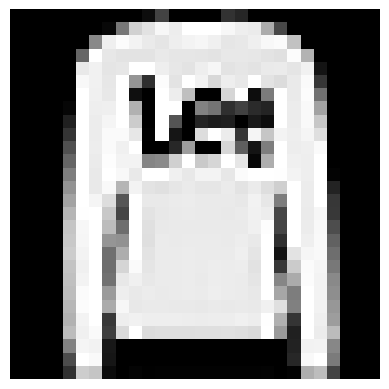

Top 5 produtos recomendados:


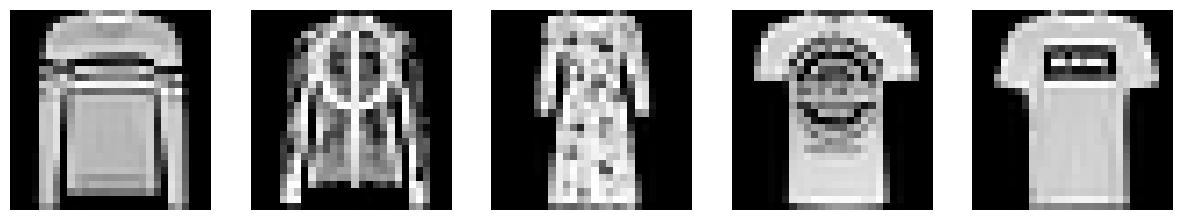

In [27]:
# Função para recomendar produtos similares
def recommend_similar_products(query_image, n_recommendations=5):
    # Extraindo características da imagem de consulta
    query_feature = extract_features([query_image])[0]

    # Encontrando os vizinhos mais próximos
    distances, indices = nn_model.kneighbors([query_feature])

    # Exibindo os resultados
    print("Imagem de consulta:")
    plt.imshow(query_image, cmap='gray')  # Exibindo a imagem original
    plt.axis('off')
    plt.show()

    print(f"Top {n_recommendations} produtos recomendados:")
    fig, axes = plt.subplots(1, n_recommendations, figsize=(15, 3))
    for i, idx in enumerate(indices[0]):
        recommended_image = train_images_small[idx]
        axes[i].imshow(recommended_image, cmap='gray')  # Exibindo as imagens originais
        axes[i].axis('off')
    plt.show()

# Testando o sistema com uma imagem aleatória do conjunto de teste
query_index = np.random.randint(0, len(test_images_small))
query_image = test_images_small[query_index]
recommend_similar_products(query_image)

Saving sapato.png to sapato (5).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Imagem de consulta:


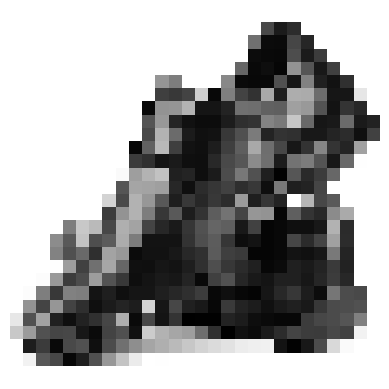

Top 5 produtos recomendados:


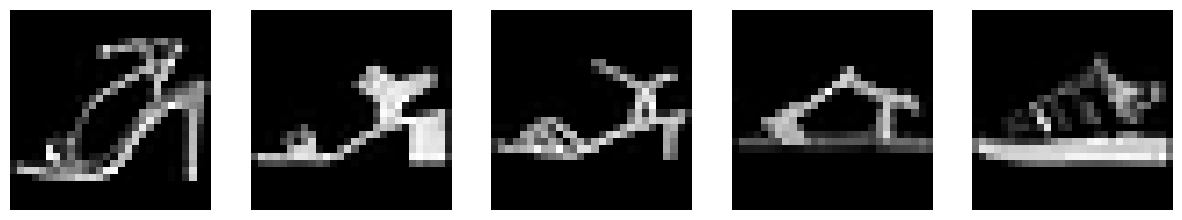

In [28]:
# Upload de uma imagem personalizada
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Carregando e processando a imagem
img = image.load_img(file_name, target_size=(28, 28), color_mode='grayscale')  # Mantendo o tamanho original
img_array = image.img_to_array(img) / 255.0

# Recomendando produtos similares
recommend_similar_products(img_array.squeeze())